**Data Scientist**: Jorge Corro

ChatGPT help me to build some code

## Record Linkage 
    
    
Let's consider that you, as a data scientist, are working for **Retailer A**, a large-scale department store chain. Retailer A has recently entered into a strategic partnership with **Retailer B**, an online e-commerce platform specializing in products. As part of this partnership, Retailer B has shared its product descriptions dataset with Retailer A for the purpose of cross-promotion, product indexing and targeted marketing.

Your task is to perform **entity resolution**, also known as record linkage, on these datasets. The goal is to identify which products in Retailer B's dataset are also products of Retailer A. This will allow the marketing department to create more personalized product offering campaigns and product indexes.

Entity resolution can be a complex task due to various reasons such as data inconsistencies, missing values, and the need to protect customer privacy. It involves several steps including data cleaning, data standardization, and matching records.

You may find the datasets in CSV format:

    - retailerA.csv
    - retailerB.csv 

### Entity resolution

Data stored in information systems are often erroneous. The
most typical errors include: inconsistent, missing, and outdated
values, typos as well as duplicates. To handle data of poor quality,
data cleaning (a.k.a. curation) and deduplication (a.k.a. entity
resolution) methods are used in projects realized by research
and industry. This is of particular challenge due
to its computational complexity and the complexity of finding
the most adequate method for comparing records and computing
similarities of these records. The similarity value of two records
is a compound value, whose computation is based on similarities
of individual attribute values.


Recall that an ER pipeline includes four basic tasks, namely:
    
- Blocking (a.k.a. indexing) - it organizes records into groups,
such that each group includes records that may include
potential duplicates.

- Block processing (a.k.a. filtering) - its goal is to eliminate
records that do not have to be compared.

- **Entity matching** (a.k.a. similarity computation) - it computes similarity values between records compared in pairs,
i.e., a value of each attribute in one record is compared to
a value of a corresponding attribute in the second record.

- **Entity clustering** - it aims at creating groups of similar records, from pairs of records representing highly probable duplicates.


For simplicity, we are going to focus on entity matching and entity clustering. This is a fairly basic pipeline and it can be extended in many ways. For example, sophisticated pre-processing and matching algorithms can be used. Or thinking about how to scale the entity resolution (i.e. speeding up the process without sacrificying accuracy).

Paper about Entity Resolution (ER): https://ceur-ws.org/Vol-3369/paper3.pdf


## Step 1: Data cleaning

Perform data cleaning with the help of regex expressions, removal of stopwords and the tokenization of the documents/sentences or paragraphs. Things like casing, extra spaces, quotes and new lines can be ignored (not limited to that though).

spaCy provides a one-stop-shop for tasks commonly used in any NLP project, so they might have all these functionalities. It useful to explore other packages like NTLK, or build the cleaning steps yourself.


The recommended workflow is the following: Read in the CSV files and apply the data cleaning operations.

***Hint***: https://www.nltk.org/api/nltk.tokenize.html

In [43]:
import pandas as pd
import numpy as np
import re
import csv
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline

In [44]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jorgeccorrov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jorgeccorrov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

This is not the required structure, it is way of encouraging modular and readable code, it is highly appreciated :) 

We add convert all words to lowecases, remove both newlines and extra whitespace, stop words in English, and tokenize:

In [45]:

stop_words = set(stopwords.words('english'))

def tokenizeData(text_attribute):
    if not text_attribute.strip():
        return []  # Return empty list for empty strings

    text_attribute = text_attribute.lower()
    text_attribute = re.sub(r'\n', ' ', text_attribute)
    text_attribute = re.sub(r'\s+', ' ', text_attribute).strip()
    text_attribute = re.sub(r"[^\w\s'-.]", '', text_attribute)

    # Tokenize the text
    tokens = word_tokenize(text_attribute)

    # Filter out stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    return filtered_tokens


Here, we create a dictionary to access easier to the columns

We apply the functions to the columns that we want

In [46]:

def readData(input_filename, columns_to_tokenize):
    data = []

    with open(input_filename, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            for column in columns_to_tokenize:
                if column in row and isinstance(row[column], str) and row[column].strip():
                    row[column] = tokenizeData(row[column])
            data.append(row)
            
    return data


In [47]:
columns_to_tokenize = ['title', 'description', 'price']

retailerA_data = readData('retailerA.csv', columns_to_tokenize) 
retailerB_data = readData('retailerB.csv', columns_to_tokenize)

In [48]:
def writeDataToDisk(data, output_filename):

  with open(output_filename, 'w', newline='', encoding='utf-8') as f:
    
    writer = csv.DictWriter(f, fieldnames=data[0].keys())
    writer.writeheader()
    writer.writerows(data)

In [49]:
for data in [retailerA_data, retailerB_data]:
    for row in data:
        title = row['title']

        # Check if title is a list
        if isinstance(title, list):
            # Join the words in the list to form a single string
            cleaned_title = ' '.join(title)
            row['title'] = cleaned_title

        else:
            # If it's already a string, no action needed
            pass

Exporting the clean files to disk

In [50]:
writeDataToDisk(retailerA_data, 'clean_retailerA.csv')
writeDataToDisk(retailerB_data, 'clean_retailerB.csv')

## Step 2: Entity Matching

For every product record in the retailer A, we need to compute its similarity to every record in retailer B- Think about the total number of comparisons you need to perform.

A very simple approach would be to use rule matching based on matches from regular expressions. Very powerful techniques can also arise from fuzzy matching and string distance algorithms. One could also try, for example, computing text similarity among sentences/documents/paragraphs using different model or feature extractors, and then compute similarities based on vector distances (i.e. cosine,euclidean,jaccard ) similarity. You may use the following model (not restricted to though):

- **Bag of Words (BoW)** Scikit-Learn, NTLK
- **N-grams**: Scikit-Learn, NTLK
- **TF-IDF**: Scikit-Learn, NTLK
- **Word embedding models**: Word2Vec ( Spacy, Gensim are packages that have this functionality)
- **Pre-trained language models**: BERT and large language models

**Extra**: There are ways to avoid this large number of comparisons among entities, they involve sophisticated methods like inserting blocking pipelines. Research this area, only after you have completed all the steps, and as an. You can opt to save the intermediary files (i.e. pairwise similarity matrix) to disk to avoid computing this step every single time. There are also additional open source libraries in python that you may use for the end-to-end entity resolution or parts of it, exclusively dedicated  to ER: *RecordLinkage*, *dedupe*, *Zingg*.

In [51]:
vectorizer = TfidfVectorizer()

def computeSimilarity(record1, record2):
    # Combine the records into a list for vectorization
    records = [record1, record2]

    # Generate TF-IDF vectors for the two records
    tfidf_matrix = vectorizer.fit_transform(records)

    # Compute the cosine similarity between the two vectors (which is a 2x2 matrix)
    sim_score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])

    # Return the similarity score (a value between 0 and 1, where 1 means identical)
    return sim_score[0][0]

To implement this functions to our clean datasets: 

In [52]:
def read_dataset(path):
    # Read the dataset into a DataFrame
    df = pd.read_csv(path)
    return df

In [53]:
df_A = read_dataset('clean_retailerA.csv')
df_B = read_dataset('clean_retailerB.csv')

In [54]:
df_A

,unique_id,title,description,price
0,1,linksys etherfast 8-port 10100 switch - ezxs88w,"['linksys', 'etherfast', '8-port', '10100', 's...",['44.00']
1,2,linksys etherfast10100 5-port auto-sensing swi...,"['linksys', 'etherfast10100', '5-port', 'auto-...",['29.00']
2,3,netgear prosafe 5 port 10100 desktop switch - ...,"['netgear', 'prosafe', '5', 'port', '10100', '...",['40.00']
3,4,belkin f3h982-10 pro series high integrity 10 ...,"['belkin', 'f3h982-10', 'pro', 'series', 'high...",NaN
4,5,netgear prosafe 16 port 10100 rackmount switch...,"['netgear', 'prosafe', '16', 'port', '10100', ...",['131.00']
...,...,...,...,...
1076,1072,sony vaio fw series black notebook computer - ...,"['sony', 'vaio', 'fw', 'series', 'black', 'not...",NaN
1077,1073,sennheiser orange silver ear headphones - cx380,"['sennheiser', 'orange', 'silver', 'ear', 'hea...",['79.95']
1078,1074,apple iwork 09 software individual pack mac - ...,"['apple', 'iwork', '09', 'software', 'individu...",['79.00']
1079,1075,apple iwork 09 software family pack mac - mb943za,"['apple', 'iwork', '09', 'software', 'family',...",['99.00']


In [55]:
df_B

,unique_id,title,description,price
0,1,linksys etherfast ezxs88w ethernet switch - ez...,"['linksys', 'etherfast', '8-port', '10100', 's...",NaN
1,2,linksys etherfast ezxs55w ethernet switch,"['5', 'x', '10100base-tx', 'lan']",NaN
2,3,netgear prosafe fs105 ethernet switch - fs105na,"['netgear', 'fs105', 'prosafe', '5', 'port', '...",NaN
3,4,belkin pro series high integrity vgasvga monit...,"['1', 'x', 'hd-15', '-', '1', 'x', 'hd-15', '-...",NaN
4,5,netgear prosafe jfs516 ethernet switch,"['netgear', 'prosafe', '16', 'port', '10100', ...",NaN
...,...,...,...,...
1087,1072,sony vaio fw378jb notebook - vgnfw378jb,"['intel', 'centrino', '2', 'core', '2', 'duo',...",NaN
1088,1073,sennheiser cx380 sennheiser cx 380 sport ii gr...,NaN,NaN
1089,1074,iwork 09 retail-int dvd - mb942za,NaN,NaN
1090,1075,iwork 09 family pack-int dvd - mb943za,NaN,NaN


In [56]:
titles_retailerA = df_A['title'].tolist()
titles_retailerB = df_B['title'].tolist()

In [57]:

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Combine both sets of titles to fit the TF-IDF vectorization
combined_titles = titles_retailerA + titles_retailerB
tfidf_matrix = vectorizer.fit_transform(combined_titles)

# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix[:len(titles_retailerA)], tfidf_matrix[len(titles_retailerA):])


In [58]:

# Function to find matches given a similarity matrix
def find_matches(similarity_matrix, threshold=0.5):
    matches = []
    for idx_a, row in enumerate(similarity_matrix):
        for idx_b, similarity_score in enumerate(row):
            if similarity_score >= threshold:
                matches.append({
                    "Title_A": titles_retailerA[idx_a],
                    "Title_B": titles_retailerB[idx_b],
                    "Score": similarity_score
                })
    return matches



In [59]:

# Find matches above the threshold
matches = find_matches(cosine_sim_matrix, threshold=0.5)

# Create a DataFrame with the matches
matches_df = pd.DataFrame(matches)
matches_df


,Title_A,Title_B,Score
0,linksys etherfast 8-port 10100 switch - ezxs88w,linksys etherfast ezxs88w ethernet switch - ez...,0.734326
1,netgear prosafe 5 port 10100 desktop switch - ...,netgear prosafe fs105 ethernet switch - fs105na,0.598189
2,netgear prosafe 5 port 10100 desktop switch - ...,netgear prosafe fs726tp 24 port 10100 smart sw...,0.557667
3,belkin f3h982-10 pro series high integrity 10 ...,belkin pro series high integrity vgasvga monit...,0.719555
4,belkin f3h982-10 pro series high integrity 10 ...,belkin monitor cable - f3h982-25,0.502057
...,...,...,...
1003,sony vaio lv series silver all-in-one desktop ...,sony vaio lv all-in-one desktop - vgclv150j,0.687734
1004,canon xh a1s black high definition hdv camcord...,canon xh a1s - 3238b001,0.508091
1005,sony vaio fw series black notebook computer - ...,sony vaio fw378jb notebook - vgnfw378jb,0.576823
1006,apple iwork 09 software family pack mac - mb943za,iwork 09 family pack-int dvd - mb943za,0.722761


In [60]:
matches_df.to_excel('matches_df.xlsx', index=False)

## Step 3: Entity clustering

Once entities have been resolved as matches. we need to  merge them in order to produce a single representative record. This involves grouping the entities based on the similarity scores. Entities or records in the same cluster are considered to be the same.

*Hint: You can use different clustering algorithms from the [sklearn-clustering](https://scikit-learn.org/stable/modules/clustering.html) library*



We're using matches_df

In order to take the optimal number of clusters, we implement the Elbow Method.

The Elbow Method involves running the KMeans clustering for a range of cluster values (k) and then calculating the sum of squared distances from each point to its assigned center (inertia). When these overall inertia values are plotted against the number of clusters, the "elbow" point, where the rate of decrease sharply changes, can be considered a good estimate for the optimal number of clusters. 

/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/cluster/_kmeans.

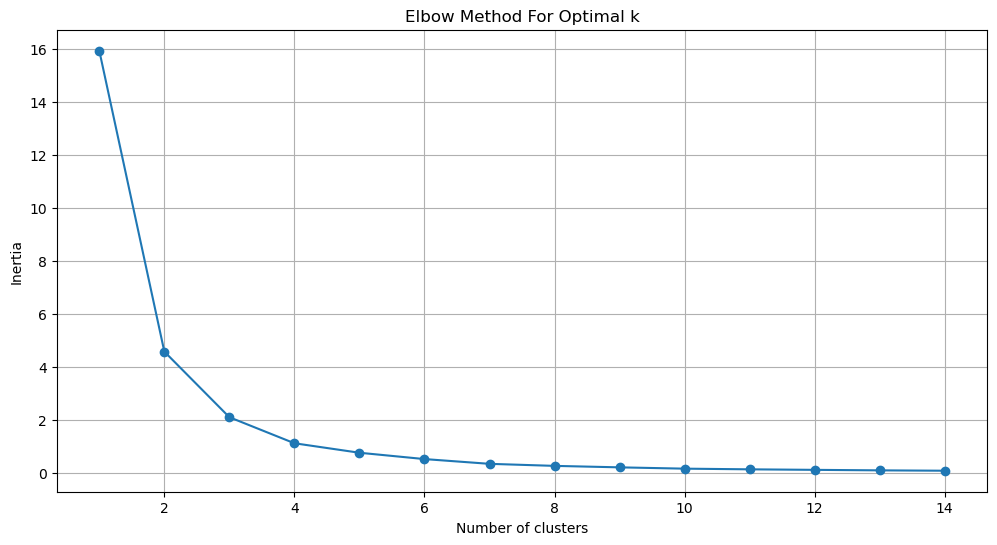

In [61]:

scores = matches_df['Score'].values.reshape(-1, 1)

# Calculating inertia for a range of k values
inertia = []
K_range = range(1, 15)  # Testing a range from 1 to 14 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(scores)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(12, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


It seems that the inertia decreases significantly as the number of clusters increases up to 4, after which the rate of decrease diminishes. This suggests that the "elbow" — the point beyond which the inertia reduction is less pronounced — is at k = 4. 

So, choosing 4 as the number of clusters would be consistent with the Elbow Method's criterion for selecting the optimal number of clusters

In [62]:

# Choosing a number of clusters (this can be adjusted)
n_clusters = 4  # Example number of clusters

# Applying KMeans clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(scores)

# Assigning the cluster labels to the DataFrame
matches_df['Cluster'] = kmeans.labels_

matches_df

/Users/jorgeccorrov/anaconda3/envs/m-bts/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Title_A,Title_B,Score,Cluster
0,linksys etherfast 8-port 10100 switch - ezxs88w,linksys etherfast ezxs88w ethernet switch - ez...,0.734326,0
1,netgear prosafe 5 port 10100 desktop switch - ...,netgear prosafe fs105 ethernet switch - fs105na,0.598189,1
2,netgear prosafe 5 port 10100 desktop switch - ...,netgear prosafe fs726tp 24 port 10100 smart sw...,0.557667,1
3,belkin f3h982-10 pro series high integrity 10 ...,belkin pro series high integrity vgasvga monit...,0.719555,3
4,belkin f3h982-10 pro series high integrity 10 ...,belkin monitor cable - f3h982-25,0.502057,1
...,...,...,...,...
1003,sony vaio lv series silver all-in-one desktop ...,sony vaio lv all-in-one desktop - vgclv150j,0.687734,3
1004,canon xh a1s black high definition hdv camcord...,canon xh a1s - 3238b001,0.508091,1
1005,sony vaio fw series black notebook computer - ...,sony vaio fw378jb notebook - vgnfw378jb,0.576823,1
1006,apple iwork 09 software family pack mac - mb943za,iwork 09 family pack-int dvd - mb943za,0.722761,0


In [63]:
matches_df.to_excel('clustered_titles_df.xlsx', index=False)

## Step 4: Writing Results


Write our original data (retailer A) back out to a CSV with a new column called ‘Cluster ID’ which indicate which records from retailer B (specified by their unique ids column) are matched to records from retailer A. Evaluate whether results are making sense by visually inspecting the dataset. You can use evaluation metrics with a groundtruth database (it will be provided later on). Your performance will be recorded.

**Extra**: You can also profile the end-to-end pipeline and record the time it takes to perform this task, argue how well your approach scales, maybe even plot running time as the number of records in the retailer´s databases  grows.


In [64]:
# TO-DO
df_A, df_B = df_A.add_suffix('_A'), df_B.add_suffix('_B')

In [65]:
df_B

,unique_id_B,title_B,description_B,price_B
0,1,linksys etherfast ezxs88w ethernet switch - ez...,"['linksys', 'etherfast', '8-port', '10100', 's...",NaN
1,2,linksys etherfast ezxs55w ethernet switch,"['5', 'x', '10100base-tx', 'lan']",NaN
2,3,netgear prosafe fs105 ethernet switch - fs105na,"['netgear', 'fs105', 'prosafe', '5', 'port', '...",NaN
3,4,belkin pro series high integrity vgasvga monit...,"['1', 'x', 'hd-15', '-', '1', 'x', 'hd-15', '-...",NaN
4,5,netgear prosafe jfs516 ethernet switch,"['netgear', 'prosafe', '16', 'port', '10100', ...",NaN
...,...,...,...,...
1087,1072,sony vaio fw378jb notebook - vgnfw378jb,"['intel', 'centrino', '2', 'core', '2', 'duo',...",NaN
1088,1073,sennheiser cx380 sennheiser cx 380 sport ii gr...,NaN,NaN
1089,1074,iwork 09 retail-int dvd - mb942za,NaN,NaN
1090,1075,iwork 09 family pack-int dvd - mb943za,NaN,NaN


In [66]:

# Merge df_A and _B with matches_df
retailer_A = pd.merge(df_A[['title_A', 'price_A']], matches_df, left_on='title_A', right_on='Title_A', how='inner')
# retailer_A
retailer = pd.merge(df_B[['title_B', 'price_B']], retailer_A, left_on='title_B', right_on='Title_B', how='inner')
retailer = retailer[['Title_A','Title_B','Score','Cluster','price_A','price_B']]
retailer


,Title_A,Title_B,Score,Cluster,price_A,price_B
0,linksys etherfast 8-port 10100 switch - ezxs88w,linksys etherfast ezxs88w ethernet switch - ez...,0.734326,0,['44.00'],NaN
1,linksys etherfast 4124 24-port ethernet switch...,linksys etherfast ezxs55w ethernet switch,0.545020,1,['119.00'],NaN
2,netgear prosafe 5 port 10100 desktop switch - ...,netgear prosafe fs105 ethernet switch - fs105na,0.598189,1,['40.00'],NaN
3,belkin f3h982-10 pro series high integrity 10 ...,belkin pro series high integrity vgasvga monit...,0.719555,3,NaN,NaN
4,belkin f3h982-25 black 25 ft pro series high i...,belkin pro series high integrity vgasvga monit...,0.665373,3,NaN,NaN
...,...,...,...,...,...,...
1167,samsung 32 ' black flat panel series 4 lcd hdt...,samsung ln32a450 32 ' 720p lcd hdtv,0.722588,0,NaN,NaN
1168,canon xh a1s black high definition hdv camcord...,canon xh a1s - 3238b001,0.508091,1,NaN,"['3,999.00']"
1169,sony vaio fw series black notebook computer - ...,sony vaio fw378jb notebook - vgnfw378jb,0.576823,1,NaN,NaN
1170,apple iwork 09 software family pack mac - mb943za,iwork 09 family pack-int dvd - mb943za,0.722761,0,['99.00'],NaN


Eliminate duplicates

In [67]:
retailer = retailer.drop_duplicates()
retailer

,Title_A,Title_B,Score,Cluster,price_A,price_B
0,linksys etherfast 8-port 10100 switch - ezxs88w,linksys etherfast ezxs88w ethernet switch - ez...,0.734326,0,['44.00'],NaN
1,linksys etherfast 4124 24-port ethernet switch...,linksys etherfast ezxs55w ethernet switch,0.545020,1,['119.00'],NaN
2,netgear prosafe 5 port 10100 desktop switch - ...,netgear prosafe fs105 ethernet switch - fs105na,0.598189,1,['40.00'],NaN
3,belkin f3h982-10 pro series high integrity 10 ...,belkin pro series high integrity vgasvga monit...,0.719555,3,NaN,NaN
4,belkin f3h982-25 black 25 ft pro series high i...,belkin pro series high integrity vgasvga monit...,0.665373,3,NaN,NaN
...,...,...,...,...,...,...
1167,samsung 32 ' black flat panel series 4 lcd hdt...,samsung ln32a450 32 ' 720p lcd hdtv,0.722588,0,NaN,NaN
1168,canon xh a1s black high definition hdv camcord...,canon xh a1s - 3238b001,0.508091,1,NaN,"['3,999.00']"
1169,sony vaio fw series black notebook computer - ...,sony vaio fw378jb notebook - vgnfw378jb,0.576823,1,NaN,NaN
1170,apple iwork 09 software family pack mac - mb943za,iwork 09 family pack-int dvd - mb943za,0.722761,0,['99.00'],NaN


Convert the price column to float

In [68]:
def convert_price_to_float(df, price_column):

    # Extract the first element if the price is in a list format
    df[price_column] = df[price_column].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith('[') else x)

    # Remove non-numeric characters and convert to float
    df[price_column] = df[price_column].replace('[\$,]', '', regex=True).astype(float)

    # Convert to numeric, coercing errors to NaN, then fill NaN with 0
    df[price_column] = pd.to_numeric(df[price_column], errors='coerce').fillna(0)

    return df

# Convert the price column for retailer
retailer = convert_price_to_float(retailer, 'price_A')
retailer = convert_price_to_float(retailer, 'price_B')
retailer



/var/folders/_m/x_6kdcg111940vvx5zz0_c7r0000gn/T/ipykernel_9817/2605531044.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[price_column] = df[price_column].apply(lambda x: eval(x)[0] if isinstance(x, str) and x.startswith('[') else x)
/var/folders/_m/x_6kdcg111940vvx5zz0_c7r0000gn/T/ipykernel_9817/2605531044.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[price_column] = df[price_column].replace('[\$,]', '', regex=True).astype(float)
/var/folders/_m/x_6kdcg111940vvx5zz0_c7r0000gn/T/ipykernel_9

,Title_A,Title_B,Score,Cluster,price_A,price_B
0,linksys etherfast 8-port 10100 switch - ezxs88w,linksys etherfast ezxs88w ethernet switch - ez...,0.734326,0,44.0,0.00
1,linksys etherfast 4124 24-port ethernet switch...,linksys etherfast ezxs55w ethernet switch,0.545020,1,119.0,0.00
2,netgear prosafe 5 port 10100 desktop switch - ...,netgear prosafe fs105 ethernet switch - fs105na,0.598189,1,40.0,0.00
3,belkin f3h982-10 pro series high integrity 10 ...,belkin pro series high integrity vgasvga monit...,0.719555,3,0.0,0.00
4,belkin f3h982-25 black 25 ft pro series high i...,belkin pro series high integrity vgasvga monit...,0.665373,3,0.0,0.00
...,...,...,...,...,...,...
1167,samsung 32 ' black flat panel series 4 lcd hdt...,samsung ln32a450 32 ' 720p lcd hdtv,0.722588,0,0.0,0.00
1168,canon xh a1s black high definition hdv camcord...,canon xh a1s - 3238b001,0.508091,1,0.0,3999.00
1169,sony vaio fw series black notebook computer - ...,sony vaio fw378jb notebook - vgnfw378jb,0.576823,1,0.0,0.00
1170,apple iwork 09 software family pack mac - mb943za,iwork 09 family pack-int dvd - mb943za,0.722761,0,99.0,0.00


In [69]:
mrs_A = retailer[retailer['price_A'] != 0]
mrs_Ac = mrs_A['price_A'].count()


mrs_B = retailer[retailer['price_B'] != 0]
mrs_Bc = mrs_B['price_B'].count()

mrs = retailer[(retailer['price_A'] != 0) & (retailer['price_B'] != 0)]
mrs_c = mrs['price_B'].count()


In [70]:
mrs_Ac_ = (mrs_Ac / retailer['price_A'].count()).round(2) * 100
mrs_Bc_ = (mrs_Bc / retailer['price_B'].count()).round(2) * 100
mrs_c_ = (mrs_c / retailer['price_A'].count()).round(2) * 100


In [71]:
comparative = {
                  'Concept': ['Price A', 'Price B', 'Combine'],
                  'No Nulls': [mrs_Ac, mrs_Bc, mrs_c],
                  'Combine %': [mrs_Ac_, mrs_Bc_, mrs_c_]
                    }
df_comparative = pd.DataFrame(comparative)
df_comparative


,Concept,No Nulls,Combine %
0,Price A,424,44.0
1,Price B,515,53.0
2,Combine,223,23.0


In [72]:
print(f"The retailerA dataset has {mrs_Ac} non null price. Meanwhile, the retailerB dataset has {mrs_Bc}. Only {mrs_c} products has price in both retailers at the same time. So let's go to compare them.")

The retailerA dataset has 424 non null price. Meanwhile, the retailerB dataset has 515. Only 223 products has price in both retailers at the same time. So let's go to compare them.


We obtain the difference in price in those 223 products

In [73]:
mrs['price_difference'] = mrs['price_A'] - mrs['price_B']

/var/folders/_m/x_6kdcg111940vvx5zz0_c7r0000gn/T/ipykernel_9817/2975386272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mrs['price_difference'] = mrs['price_A'] - mrs['price_B']


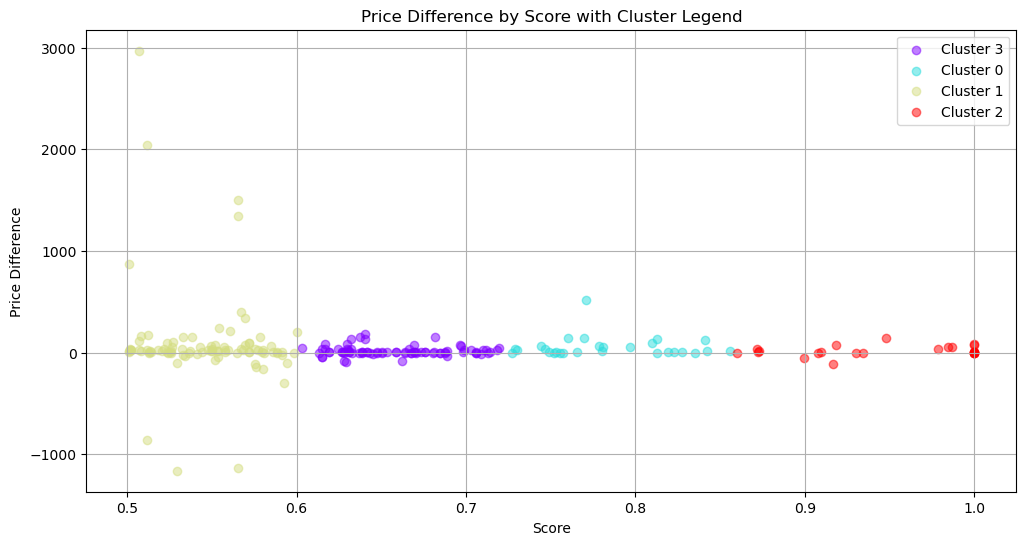

In [74]:

# Getting a colormap to assign different colors to each cluster
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_ids = mrs['Cluster'].unique()
color_map = dict(zip(cluster_ids, colors))

# Create the plot
plt.figure(figsize=(12, 6))

for cluster_id in cluster_ids:
    # Filter data for each cluster
    cluster_data = mrs[mrs['Cluster'] == cluster_id]
    plt.scatter(cluster_data['Score'], cluster_data['price_difference'], 
                color=color_map[cluster_id], label=f'Cluster {cluster_id}', alpha=0.5)

plt.title('Price Difference by Score with Cluster Legend')
plt.xlabel('Score')
plt.ylabel('Price Difference')
plt.grid(True)
plt.legend()
plt.show()



We can try to exclude outliers in the cluster 0 and 1 to understand better this graph

We can include the analysis when the prices are the same

In [75]:
def describe_with_stats(data):
    median = data.median()
    mode = data.mode().iloc[0]  # Access the first element of the mode series
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Combining statistics into a DataFrame
    stats = pd.DataFrame({
        'count': data.count(),
        'mode': mode,
        'mean': data.mean(),
        'std': data.std(),
        'min': data.min(),
        '25%': Q1,
        '50% (median)': median,
        '75%': Q3,
        'max': data.max(),
        'IQR': IQR
    })

    stats = stats.T.round({'count': 0})

    return stats

Applying for the Cluster 1

In [76]:
mrs_desc1 = mrs.copy()
mrs_desc1 = mrs_desc1[mrs_desc1['Cluster'] == 1] 
 
df1_desc = mrs_desc1[['Score','price_A','price_B','price_difference']]
df1_des = describe_with_stats(df1_desc)
df1_des


,Score,price_A,price_B,price_difference
count,91.000000,91.000000,91.000000,91.000000
mode,0.507131,39.000000,69.990000,0.000000
mean,0.546256,393.290000,301.981758,91.308242
std,0.028929,756.150684,511.302892,485.801621
min,0.500890,8.990000,6.220000,-1162.040000
25%,0.522474,46.000000,26.710000,1.495000
50% (median),0.549678,129.000000,107.580000,20.370000
75%,0.570804,313.950000,300.500000,65.495000
max,0.600152,3999.000000,3299.000000,2970.470000
IQR,0.048329,267.950000,273.790000,64.000000


In [77]:

Q1_c1 = df1_des.iloc[5, 3]
Q3_c1 = df1_des.iloc[7, 3]
IQR_c1 = df1_des.iloc[9, 3]

outliers_c1 = (mrs_desc1['price_difference'] > (Q3_c1 + 1.5 * IQR_c1)) | (mrs_desc1['price_difference'] < (Q1_c1 - 1.5 * IQR_c1))


Applying for the Cluster 0

In [78]:
mrs_desc0 = mrs.copy()
mrs_desc0 = mrs_desc0[mrs_desc0['Cluster'] == 0] 
 
df0_desc = mrs_desc0[['Score','price_A','price_B','price_difference']]
df0_des = describe_with_stats(df0_desc)
df0_des

,Score,price_A,price_B,price_difference
count,28.000000,28.000000,28.000000,28.000000
mode,0.727286,499.000000,4.650000,-5.920000
mean,0.783058,279.102143,222.517143,56.585000
std,0.038396,390.672072,300.053519,101.959882
min,0.727286,14.000000,4.650000,-5.920000
25%,0.752797,56.500000,48.082500,3.535000
50% (median),0.774586,129.000000,107.755000,19.565000
75%,0.814424,424.000000,361.500000,63.600000
max,0.856048,1995.000000,1475.990000,519.010000
IQR,0.061627,367.500000,313.417500,60.065000


In [79]:

Q1_c0 = df0_des.iloc[5, 3]
Q3_c0 = df0_des.iloc[7, 3]
IQR_c0 = df0_des.iloc[9, 3]

outliers_c0 = (mrs_desc0['price_difference'] > (Q3_c0 + 1.5 * IQR_c0)) | (mrs_desc0['price_difference'] < (Q1_c0 - 1.5 * IQR_c0))


In [80]:
mrs_out1 = mrs_desc1[~outliers_c1]
mrs_out0 = mrs_desc0[~outliers_c0]

In [81]:
mrs_nw = pd.concat([mrs[~mrs['Cluster'].isin([0, 1])], mrs_out0, mrs_out1]).reset_index(drop=True)
df_desc = mrs_nw[['Score','price_A','price_B','price_difference']]
df_des = describe_with_stats(df_desc)
df_des


,Score,price_A,price_B,price_difference
count,201.000000,201.000000,201.000000,201.000000
mode,1.000000,149.000000,146.750000,-2.750000
mean,0.670652,239.573234,216.388458,23.184776
std,0.133514,419.133529,410.194390,45.514544
min,0.501271,8.990000,4.650000,-116.600000
25%,0.567395,49.000000,36.950000,0.050000
50% (median),0.640146,144.000000,139.880000,8.550000
75%,0.727286,249.000000,206.960000,35.940000
max,1.000000,3999.000000,3999.000000,180.370000
IQR,0.159890,200.000000,170.010000,35.890000


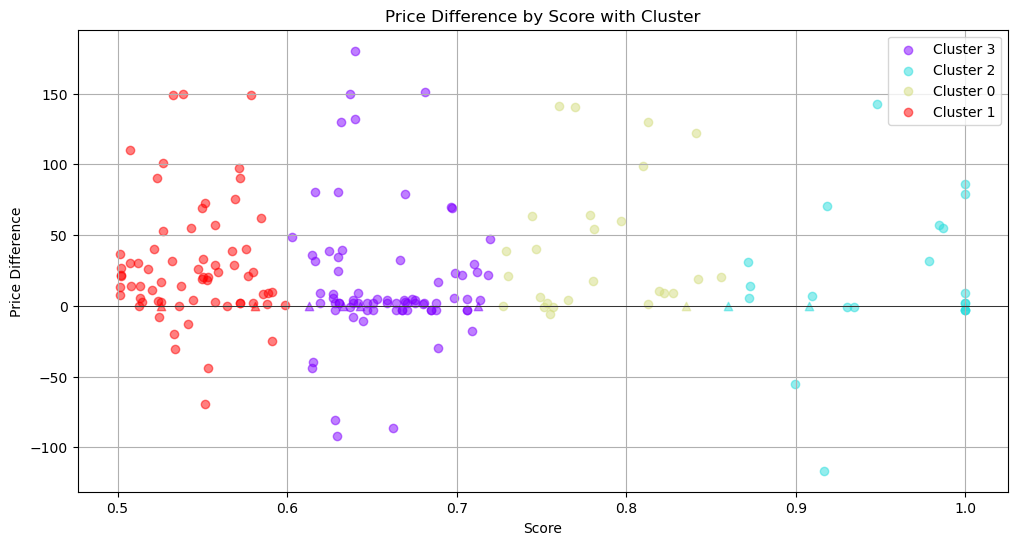

In [82]:
colors = cm.rainbow(np.linspace(0, 1, n_clusters))
cluster_ids = mrs_nw['Cluster'].unique()
color_map = dict(zip(cluster_ids, colors))

# Create the plot
plt.figure(figsize=(12, 6))

for cluster_id in cluster_ids:
    # Filter data for each cluster
    cluster_data = mrs_nw[mrs_nw['Cluster'] == cluster_id]
    
    # Plot data points where price difference is not zero
    non_zero_diff = cluster_data[cluster_data['price_difference'] != 0]
    plt.scatter(non_zero_diff['Score'], non_zero_diff['price_difference'], 
                color=color_map[cluster_id], label=f'Cluster {cluster_id}', alpha=0.5)
    
    # Plot data points where price difference is zero with a triangle marker
    zero_diff = cluster_data[cluster_data['price_difference'] == 0]
    plt.scatter(zero_diff['Score'], zero_diff['price_difference'], 
                color=color_map[cluster_id], marker='^', alpha=0.5)

plt.title('Price Difference by Score with Cluster')
plt.xlabel('Score')
plt.ylabel('Price Difference')
plt.axhline(0, color='black', linewidth=0.5)  # Horizontal line for price difference zero
plt.grid(True)
plt.legend()
plt.show()

Before finish we can conclude that: 
* The according the Elbow Method with, we have clustered by 4

* **Price Difference Variation**: Most of the data points seem to cluster around a zero price difference, as indicated by the horizontal line. The triangles at the zero mark on the y-axis means no differences. 

* This could mean that for many product pairs, there is no significant price differences.

* However, those pairs which already have differences, we can see that the most of them RetailerA had higher prices than the RetailerB.

Last but not less important, we print out the completely dataset clustered by, to be able to visualize how our works brought together the products from both datasets

In [83]:
retailer = retailer.sort_values(by='Cluster')
retailer['price_difference'] = retailer['price_A'] - retailer['price_B']
retailer_http = retailer.style.set_properties()
retailer_http

,Title_A,Title_B,Score,Cluster,price_A,price_B,price_difference
0,linksys etherfast 8-port 10100 switch - ezxs88w,linksys etherfast ezxs88w ethernet switch - ezxs88w,0.734326,0,44.000000,0.000000,44.000000
335,kenwood kca-ip200 black ipod direct cable - kcaip200,kenwood ipod direct cable - kcaip200,0.776222,0,0.000000,19.720000,-19.720000
351,uniden dect 6.0 accessory handset charging cradle - dcx200,uniden dcx200 dect 6.0 accessory handset charger,0.746534,0,0.000000,0.000000,0.000000
358,nikon coolpix leather camera case black - 5811,nikon digital camera leather case - 5811,0.858006,0,0.000000,7.990000,-7.990000
362,bracketron ipod docking kit - ipm202bl,bracketron ipod docking kit,0.819133,0,14.950000,4.650000,10.300000
365,canon pixma multifunction printer - mx310,canon pixma mx310 multifunction photo printer - 2184b002,0.810322,0,0.000000,89.990000,-89.990000
373,ge amplified quantum antenna - tv24775,ge 24775 amplified quantum hdtv antenna,0.725673,0,0.000000,0.000000,0.000000
383,lacie little disk 250gb black portable hard drive - 301278,lacie little disk hard drive - 301278,0.842385,0,99.000000,79.990000,19.010000
386,klipsch black wireless ipod speaker - roomgroove,klipsch roomgroove wireless ipod speaker system - 1006602,0.809923,0,299.000000,199.990000,99.010000
388,sony 2gb memory stick micro ( m2 ) - msa2gu2,sony 2gb memory stick micro ( m2 ) - msa2gd,0.750712,0,29.990000,0.000000,29.990000
